# Confusion Matrices (GFS, HRRR, RAP) 

In [265]:
import numpy as np
import xarray as xr
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, multilabel_confusion_matrix
from ptype.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from collections import Counter 
import os 
from itertools import chain
import itertools


In [268]:
ds = xr.open_dataset("/glade/campaign/cisl/aiml/ptype/ptype_case_studies/kentucky/rap/20220223/0000/MILES_ptype_rap_2022-02-23_0000_f01.nc")
ds

<xarray.Dataset>
Dimensions:                  (time: 1, heightAboveGround: 21, y: 337, x: 451,
                              isobaricInhPa: 37)
Coordinates:
  * heightAboveGround        (heightAboveGround) int64 0 250 500 ... 4750 5000
  * time                     (time) datetime64[ns] 2022-02-23
    step                     timedelta64[ns] ...
  * isobaricInhPa            (isobaricInhPa) float32 1e+03 975.0 ... 125.0 100.0
    latitude                 (y, x) float32 ...
    longitude                (y, x) float32 ...
    valid_time               datetime64[ns] ...
    y_projection_coordinate  (y) float32 ...
    x_projection_coordinate  (x) float32 ...
Dimensions without coordinates: y, x
Data variables: (12/29)
    t_h                      (time, heightAboveGround, y, x) float32 ...
    dpt_h                    (time, heightAboveGround, y, x) float32 ...
    u_h                      (time, heightAboveGround, y, x) float32 ...
    v_h                      (time, heightAboveGround, y, x) float32 ...
    isobaricInhPa_h          (time, heightAboveGround, y, x) float64 ...
    t                        (time, isobaricInhPa, y, x) float32 ...
    ...                       ...
    ML_snow                  (time, y, x) float32 ...
    ML_csnow                 (time, y, x) uint8 ...
    ML_icep                  (time, y, x) float32 ...
    ML_cicep                 (time, y, x) uint8 ...
    ML_frzr                  (time, y, x) float32 ...
    ML_cfrzr                 (time, y, x) uint8 ...

In [267]:
#load all the files:
data_set = xr.open_mfdataset("/glade/campaign/cisl/aiml/ptype/ptype_case_studies/kentucky/rap/20220223/0000/*.nc",concat_dim= "time",combine="nested")

In [ ]:
# todos 06/07: 

# debug the incorrect number of files 
# loop thru 100 files and extract the data for the 8 data variables.
# plot confusion matrices for KY  
# subplot() 

# NY case 1
# NY case 2 

In [300]:
def get_file_paths(case_study:str, model_name: str)-> list:
    
    ''' Loop through the files and returns a list of file paths'''
    
    base_path = f"/glade/campaign/cisl/aiml/ptype/ptype_case_studies/{case_study}/{model_name}"
    init = os.listdir(base_path)  
    file_names = []
    full_path_names = []

    for each_date in init:  # there is not 20220224 
        hours = os.listdir(os.path.join(base_path, each_date))
        for each_hour in hours: 
            file_names.append(os.listdir(os.path.join(base_path, each_date, each_hour)))
            joined_list = [item for sublist in file_names for item in sublist] #432
            for each_file in joined_list:
                full_path_names.append(os.path.join(base_path, each_date, each_hour, each_file))
    return full_path_names

# getting incorrect # of file paths 

In [301]:
# getting the lists with the file names: 
case_ky = get_file_paths("kentucky", "rap")
len(case_ky)

21168

In [297]:
# Variables to store the vals in all the files
ML_crain = []
ML_csnow = []
ML_cicep = []
ML_cfrzr = []

crain = []
csnow =[]
cicep =[]
cfrzr=[]


for each_file in range(len(case_ky)-764): # loop thru first 100
    ds = xr.open_dataset(case_ky[each_file])  
    ML_crain.append(ds['ML_crain'].values.flatten()) 
    ML_csnow.append(ds['ML_csnow'].values.flatten()) 
    ML_cicep.append(ds['ML_cicep'].values.flatten()) 
    ML_cfrzr.append(ds['ML_cfrzr'].values.flatten()) 
    
    
#/glade/campaign/cisl/aiml/ptype/ptype_case_studies/kentucky/rap/20220223/1100/MILES_ptype_rap_2022-02-23_1600_f01.nc'

In [134]:
os.listdir("/glade/campaign/cisl/aiml/ptype/ptype_case_studies/kentucky/")

['hrrr', 'gfs', 'rap']

In [135]:
pred= ds['ML_crain'].values.flatten() #convertir todo en 1d 
print(type(pred))
pred = np.zeros(shape=pred.shape) # convertir todo los valores en 0
print((type(pred)))
class_names = ['rain', 'snow', 'sleet', 'frz-rain']

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


In [136]:
rain_i = np.where(ds['ML_crain'].values.flatten()==1) # categorical data
snow_i = np.where(ds['ML_csnow'].values.flatten()==1) 
sleet_i = np.where(ds['ML_cicep'].values.flatten()==1)  
frzr_i = np.where(ds['ML_cfrzr'].values.flatten()==1)

pred[rain_i]=0
pred[snow_i]=1
pred[sleet_i]=2
pred[frzr_i]=3

In [137]:
Counter(pred)

Counter({0.0: 78853, 1.0: 66955, 3.0: 4181, 2.0: 1998})

In [138]:
truth = ds['crain'].values.flatten()
truth = np.zeros(shape=truth.shape)

In [63]:
rain_i_T = np.where(ds['crain'].values.flatten()==1)
snow_i_T= np.where(ds['csnow'].values.flatten()==1) 
sleet_i_T= np.where(ds['cicep'].values.flatten()==1) 
frzr_i_T= np.where(ds['cfrzr'].values.flatten()==1) 

truth[rain_i_T]=0
truth[snow_i_T]=1
truth[sleet_i_T]=2
truth[frzr_i_T]=3

In [103]:
def plot_CM(truth: xr, pred: xr, norm_val: str):
    ''' Funtion that plots a confusion matrix: 
        norm_val also takes None '''
    
    cm = confusion_matrix(truth, pred, normalize=norm_val)
    ConfusionMatrixDisplay(cm)

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    
    if norm_val == 'true':
        title = "Normalized"
    elif norm_val == 'pred':
        title = "Normalized Prediction"
    else: 
        title = ""
        

    plt.title(f'Confusion Matrix {title}')
    plt.show()

### Case Study 1: Kentucky

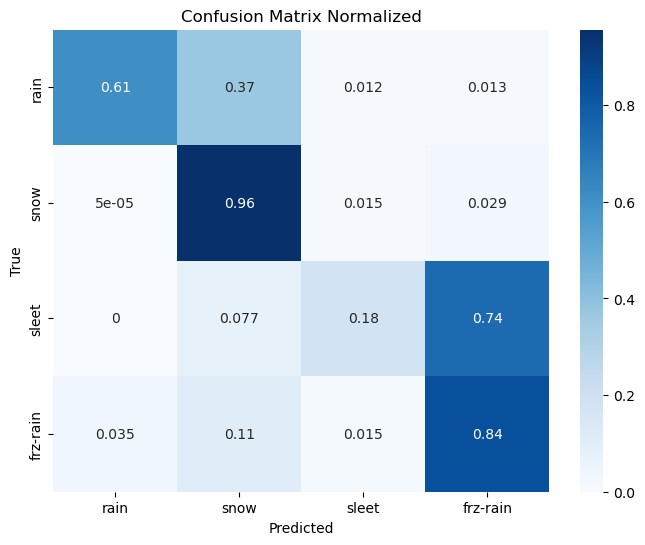

In [104]:
#TODO-> subplot for each case 
plot_CM(truth, pred,'true')

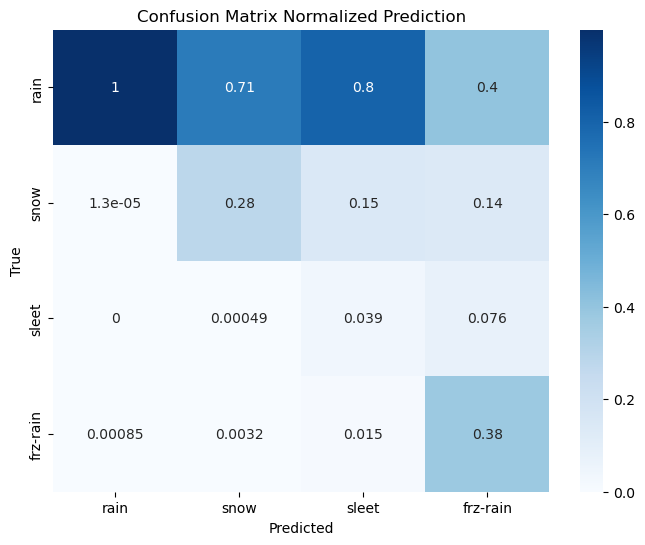

In [105]:
plot_CM(truth, pred,'pred')

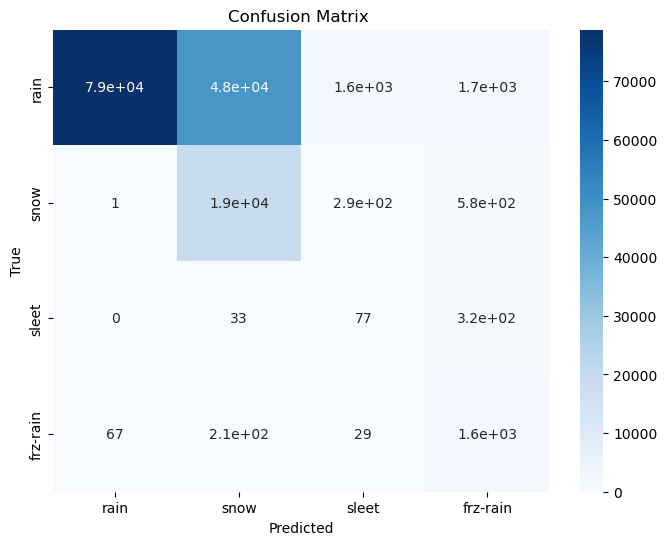

In [106]:
plot_CM(truth, pred, None)